# PyWR

Load libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
#import eccodes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# key PyWR functions are imported here
from PyWR import *
import matplotlib.path as mpath

In [2]:
# Spatial domain
nla=55  	# Northernmost latitude
sla=20  	# Southernmost latitude
wlo=-140 	# Westernmost longitude
elo=-100 	# Easternmost longitude
#Time domain:
season='Jan-Dec'
yeari= 1982
yeare= 2010
#Indicate if force download all data (True in case it's corrupted or new one is needed)
force=True

# Prepare Data (if needed)

This section downloads data (as needed; details below).

First, let's create a `data` and a `figs` folder. If already there, it won't create anything.

In [3]:
!mkdir -p WUS
!cd WUS
!mkdir -p WUS/data/
!mkdir -p figs

To download data from the IRI data library, you need an authentication key. This is stored in a file called `.IRIDLAUTH`, but is not part of the GitHub repository -- you need to contact the IRI Data Library to request access. Once you have done so, you can put your own authentication key in a file called `.IRIDLAUTH` and use this code. This is a moderately annoying step, and we apologize, but it is required by the S2S Database Terms and Conditions and is necessary for us to share all our code while maintaining some security.

**NB** if you're using `git`, be sure to add `.IRIDLAUTH` to your `gitignore` file :)

In [4]:
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

## Reanalysis and obs data (preprocessing)

Here we download all the data needed, using the spatial and temporal domains defined above. We download the physical field used to build the weather types (geopotential height anomalies at 500 mb in this case), winds (500 mb), rainfall and temperature fields. A 5-day moving average is applied to the fields before computing the daily anomalies (daily climatologies are computed via the naïve approach).

Important: some of the datasets are huge. If the data is already downloaded and ok (e.g., not corrupted) but we wanted to re-download it, set `force_download=True` below (each dataset can be controlled independently).

In [5]:
#includes the full coordinates for the polar stereo reprojection
reanalysisFull = download_data(
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(3%20Sep%202017)/VALUE/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/hdate/(1997)/(2016)/RANGE/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202019-01-01)/streamgridunitconvert/S//units//days/def/L/0.5/add/hdate/add/add//pointwidth/1/def/SOURCES/.ECMWF/.ERA-Interim/.SIX-HOURLY/.pressure_level/.z500/T/3/shiftGRID/T/24/boxAverage/T/2/index/.units/streamgridunitconvert/exch/%5BT%5Dsample-along/c%3A/9.81/(m%20s-2)/%3Ac/div/S/removeGRID/L/5/runningAverage/%5BX/Y%5D/1.0/0./regridLinear/dup/%5Bhdate%5Daverage/2/RECHUNK/sub/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NASA/.NCCS_Dataserver/.CREATE_REANALYSIS/.MERRA2/.day/.atmos/.zg/plev/500/VALUE/plev/removeGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/-0.875/shiftGRID/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/data.nc',
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.phi/P/(500)/VALUE/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/(-180)/(180)/RANGE/Y/(0)/(90)/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/T//pointwidth/0/def/pop/T/-.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/-0.5/shiftGRID/data.nc',
    outfile='WUS/data/hgt_NNRP_rean.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])
reanalysisFull

<xarray.Dataset>
Dimensions:  (P: 1, grid: 5365, time: 10588)
Coordinates:
  * P        (P) int32 500
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 90.0 90.0 90.0 90.0 90.0
  - X        (grid) float64 -180.0 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    adif     (P, time, grid) float32 7.897 8.138 7.221 ... -43.16 -43.16 -43.16

In [6]:
#unstacks the grid and selects the subset of coordinates used for the original projection
reanalysis = reanalysisFull.unstack("grid")
reanalysis = reanalysis.sel(Y=slice(sla,nla),X=slice(wlo,elo))
reanalysis = reanalysis.stack(grid=("Y","X"))
reanalysis

<xarray.Dataset>
Dimensions:  (P: 1, grid: 255, time: 10588)
Coordinates:
  * P        (P) int32 500
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 20.0 20.0 20.0 20.0 20.0 ... 55.0 55.0 55.0 55.0
  - X        (grid) float64 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
Data variables:
    adif     (P, time, grid) float32 13.86 15.0 16.79 ... -92.83 -77.81 -59.26

In [7]:
#uwnd = download_data(
#    url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.u/%5BX/Y%5D/regridAverage/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/P/(850)/VALUE/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.u/home/.agmunoz/.NNRP/.chi_200/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/gridtomatch/P/850/VALUE/T/1/boxAverage/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/%5BT%5D/average/sub/data.nc',
#    outfile='WUS/data/u_NNRP_rean.nc', 
#    authkey=authkey,
#    force_download=force
#).stack(time=['T'], grid=['Y', 'X'])

In [8]:
#vwnd = download_data(
#    url='http://iridl.ldeo.columbia.edu/home/.agmunoz/.NNRP/.chi_200/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.v/%5BX/Y%5D/regridAverage/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/P/(850)/VALUE/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.DAILY/.Intrinsic/.PressureLevel/.v/home/.agmunoz/.NNRP/.chi_200/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/gridtomatch/P/850/VALUE//T/1/boxAverage/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/%5BT%5D/average/sub/data.nc',
#    outfile='WUS/data/v_NNRP_rean.nc', 
#    authkey=authkey,
#    force_download=force
#).stack(time=['T'], grid=['Y', 'X'])

In [9]:
rainfall = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/%28%201%20Jan%20'+str(yeari)+'%29/%2830%20Dec%20'+str(yeare)+'%29/RANGEEDGES/T//pointwidth/0/def/0./shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/%28days%20since%201960-01-01%2000:00:00%29/streamgridunitconvert/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/-0.5/shiftGRID/data.nc',
    outfile='WUS/data/rainfall_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])
rainfall

<xarray.Dataset>
Dimensions:  (grid: 5904, time: 10588)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 19.75 19.75 19.75 19.75 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -140.2 -139.8 -139.2 -138.8 ... -100.8 -100.2 -99.75
Data variables:
    adif     (time, grid) float32 nan nan nan nan ... -0.4358 -0.4301 -0.4228

In [10]:
t2m  = download_data(
    url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/T/(days%20since%201960-01-01%2000%3A00%3A00)/streamgridunitconvert/T/(Jan-Dec%201985-2015)/RANGE/T//pointwidth/0/def/-0.5/shiftGRID/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/dup/T/to366daysample/%5BYR%5Daverage/T/sampleDOY/sub/T/5/runningAverage/T/0.5/shiftGRID/data.nc',
    #url='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/add/2/div/X/('+str(wlo)+')/('+str(elo)+')/RANGE/Y/('+str(sla)+')/('+str(nla)+')/RANGE/T/5/runningAverage/T/('+season+'%20'+str(yeari)+'-'+str(yeare)+')/RANGE/dup/T/to366daysample%5BYR%5Daverage/T/sampleDOY/sub/data.nc',
    outfile='WUS/data/t2m_cpc.nc', 
    authkey=authkey,
    force_download=force
).stack(time=['T'], grid=['Y', 'X'])

In [11]:
reanalysis=reanalysis.isel(P=0)
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 255, time: 10588)
Coordinates:
    P        int32 500
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 20.0 20.0 20.0 20.0 20.0 ... 55.0 55.0 55.0 55.0
  - X        (grid) float64 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
Data variables:
    adif     (time, grid) float32 13.86 15.0 16.79 ... -92.83 -77.81 -59.26

In [12]:
reanalysisFull=reanalysisFull.isel(P=0)

In [13]:
rainfall

<xarray.Dataset>
Dimensions:  (grid: 5904, time: 10588)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 19.75 19.75 19.75 19.75 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -140.2 -139.8 -139.2 -138.8 ... -100.8 -100.2 -99.75
Data variables:
    adif     (time, grid) float32 nan nan nan nan ... -0.4358 -0.4301 -0.4228

In [14]:
t2m

<xarray.Dataset>
Dimensions:  (grid: 5904, time: 11318)
Coordinates:
  * time     (time) MultiIndex
  - T        (time) float64 9.134e+03 9.136e+03 ... 2.045e+04 2.045e+04
  * grid     (grid) MultiIndex
  - Y        (grid) float64 19.75 19.75 19.75 19.75 ... 55.25 55.25 55.25 55.25
  - X        (grid) float64 -140.2 -139.8 -139.2 -138.8 ... -100.8 -100.2 -99.75
Data variables:
    asum     (time, grid) float32 nan nan nan nan ... 2.821 2.629 2.249 1.728

# Dimension Reduction

We need to choose a percentage of variance explained that we will require:

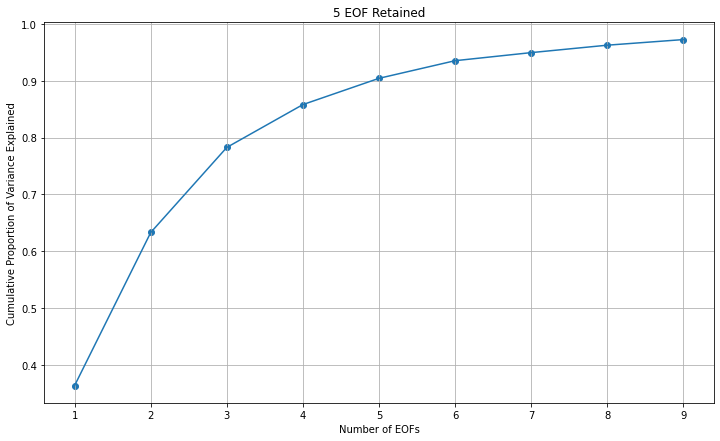

In [15]:
n_eof = get_number_eof(X=reanalysis['adif'].values, var_to_explain=0.9, plot=True)

Now we project the data onto the leading EOFs to get the principal component time series.
We will retain the PCA model for use later.
The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [16]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['adif'].values)
reanalysis_pc = pca_model.transform(reanalysis['adif'].values)

# Reanalysis Weather Typing

Now we perform the clustering.
We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [17]:
ncluster = 6 # use 6 WTs
n_sim = 25 # typically 25-50 -- try 25 for quick preliminary computation only

Now we can use this to run the classifiability index on our centroids

In [18]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print('The classifiability index is {}'.format(class_idx))

/Users/drewr/git_drewr/PyWR/Weather-typing/PyWR.py:132: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "loop_kmeans" failed type inference due to: Untyped global name 'KMeans': Cannot determine Numba type of <class 'type'>

File "PyWR.py", line 145:
def loop_kmeans(X: np.ndarray, n_cluster: int, n_sim: int) -> Tuple[np.ndarray, np.ndarray]:
    <source elided>
    for i in np.arange(n_sim):
        km = KMeans(n_clusters=n_cluster).fit(X)
        ^

  @jit
/Users/drewr/git_drewr/PyWR/Weather-typing/PyWR.py:132: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "loop_kmeans" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "PyWR.py", line 144:
def loop_kmeans(X: np.ndarray, n_cluster: int, n_sim: int) -> Tuple[np.ndarray, np.ndarray]:
    <source elided>
    w_types = np.zeros(shape=(n_sim, X.shape[0]))
    for i in np.ara

The classifiability index is 1.0


Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [19]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

In [20]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    model_clust, 
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['adif']
reanalysis_composite['M'] = 0

In [21]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)
wt_anomalies

[<xarray.DataArray 'adif' (WT: 6, Y: 15, X: 17)>
 array([[[ 3.54579782e+00,  3.22337532e+00,  2.92971277e+00, ...,
          -9.51490879e-01, -1.50717020e+00, -2.05833888e+00],
         [ 1.57403243e+00,  1.40275395e+00,  1.41887498e+00, ...,
          -8.14078033e-01, -1.69258165e+00, -2.64920807e+00],
         [-2.31357074e+00, -2.19101405e+00, -1.71682262e+00, ...,
           2.89918125e-01, -1.03266501e+00, -2.58402729e+00],
         ...,
         [-4.71984444e+01, -3.70204964e+01, -2.42664967e+01, ...,
           7.92984009e+01,  7.52992783e+01,  6.94670029e+01],
         [-3.42709427e+01, -2.45516243e+01, -1.28688374e+01, ...,
           7.77867355e+01,  7.37245102e+01,  6.79187088e+01],
         [-2.11516113e+01, -1.25976315e+01, -2.67731118e+00, ...,
           7.12774200e+01,  6.74220276e+01,  6.20771790e+01]],
 
        [[-4.85094309e+00, -4.07022095e+00, -3.05529428e+00, ...,
          -1.70105624e+00, -1.48996711e+00, -1.31893528e+00],
         [-4.86129284e+00, -3.51803565

In [22]:

wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1
wt_anomalies

<xarray.DataArray 'adif' (M: 1, WT: 6, Y: 15, X: 17)>
array([[[[ 3.54579782e+00,  3.22337532e+00,  2.92971277e+00, ...,
          -9.51490879e-01, -1.50717020e+00, -2.05833888e+00],
         [ 1.57403243e+00,  1.40275395e+00,  1.41887498e+00, ...,
          -8.14078033e-01, -1.69258165e+00, -2.64920807e+00],
         [-2.31357074e+00, -2.19101405e+00, -1.71682262e+00, ...,
           2.89918125e-01, -1.03266501e+00, -2.58402729e+00],
         ...,
         [-4.71984444e+01, -3.70204964e+01, -2.42664967e+01, ...,
           7.92984009e+01,  7.52992783e+01,  6.94670029e+01],
         [-3.42709427e+01, -2.45516243e+01, -1.28688374e+01, ...,
           7.77867355e+01,  7.37245102e+01,  6.79187088e+01],
         [-2.11516113e+01, -1.25976315e+01, -2.67731118e+00, ...,
           7.12774200e+01,  6.74220276e+01,  6.20771790e+01]],

        [[-4.85094309e+00, -4.07022095e+00, -3.05529428e+00, ...,
          -1.70105624e+00, -1.48996711e+00, -1.31893528e+00],
         [-4.86129284e+00, -3.51803565e+00, -1.90378392e+00, ...,
          -1.83826554e+00, -1.97754133e+00, -2.15190029e+00],
         [-4.31519794e+00, -2.22431946e+00,  1.81003839e-01, ...,
          -1.34274077e+00, -2.06074500e+00, -2.87964964e+00],
...
          -4.49001045e+01, -4.89750404e+01, -5.11128960e+01],
         [ 1.19268120e+02,  1.17118813e+02,  1.10514519e+02, ...,
          -3.99417458e+01, -4.46186676e+01, -4.74755287e+01],
         [ 1.07268631e+02,  1.04766449e+02,  9.85605698e+01, ...,
          -3.40012817e+01, -3.86731644e+01, -4.17440491e+01]],

        [[-3.32306075e+00, -3.22973609e+00, -3.20891881e+00, ...,
           4.20655823e+00,  4.92146063e+00,  5.43395233e+00],
         [-3.59869242e+00, -3.97598004e+00, -4.56214142e+00, ...,
           4.73902035e+00,  6.21169186e+00,  7.44947720e+00],
         [-2.82051373e+00, -4.04222059e+00, -5.65702343e+00, ...,
           3.72919273e+00,  6.30394173e+00,  8.67042255e+00],
         ...,
         [ 3.66352501e+01,  1.58520613e+01, -6.25651979e+00, ...,
          -6.67162247e+01, -5.57628632e+01, -4.40392456e+01],
         [ 3.27900009e+01,  1.41641970e+01, -5.31462288e+00, ...,
          -6.23466988e+01, -5.31703644e+01, -4.31978378e+01],
         [ 2.72725677e+01,  1.16506901e+01, -4.47389317e+00, ...,
          -5.55033073e+01, -4.84868050e+01, -4.06368790e+01]]]],
      dtype=float32)
Coordinates:
    P        int32 500
  * WT       (WT) int64 1 2 3 4 5 6
  * Y        (Y) float64 20.0 22.5 25.0 27.5 30.0 ... 45.0 47.5 50.0 52.5 55.0
  * X        (X) float64 -140.0 -137.5 -135.0 -132.5 ... -105.0 -102.5 -100.0
  * M        (M) int64 0

Plot as a function of WT and ensemble member.
Note `M=0` for reanalysis

In [23]:
# plt.rcParams.update({'font.size': 12})

# p = wt_anomalies.plot.contourf(
#     x='X', y='Y', col='WT', row='M',
#     transform=ccrs.PlateCarree(),
#     subplot_kws={
#         'projection': ccrs.PlateCarree()#ccrs.Orthographic(-90, 0)
#         #ccrs.PlateCarree()
#     },
#     figsize=(10, 10),
#     levels = np.linspace(-400000, 400000, 11),
#     cmap=plt.cm.bwr,
#     extend='both'
# )

# xmin,xmax = wt_anomalies['X'].min(), wt_anomalies['X'].max()
# ymin,ymax = wt_anomalies['Y'].min(), wt_anomalies['Y'].max()
# for ax in p.axes.flat:
#     ax.coastlines()
#     ax.add_feature(feature.BORDERS)
#     ax.set_extent([xmin, xmax, ymin, ymax])

# plt.show()

Now, let's prepare a figure with rainfall and temperature composites

In [24]:
X, Y = np.meshgrid(reanalysis['adif'].X, reanalysis['adif'].Y)
map_proj = ccrs.PlateCarree() #ccrs.Orthographic(-110, 10)
data_proj = ccrs.PlateCarree()
wt_unique = np.unique(wt_anomalies['WT'])
figsize = (14, 8)
#plot_region = Region(lon = [wlo, elo], lat = [sla, nla])

In [25]:
#WT proportions
wt=weather_types.to_dataframe(name='WT')
wt=wt+1
#wt.to_netcdf('data/t2m_cpc.nc', format="NETCDF4")
wt_counts = wt.groupby('WT').size().div(wt['WT'].size)
wt_counts

WT
1    0.200982
2    0.122686
3    0.217888
4    0.131658
5    0.176898
6    0.149887
dtype: float64

In [26]:
wt

,WT
T,
8038.5,6
8039.5,6
8040.5,6
8041.5,6
8042.5,5
...,...
18621.5,4
18622.5,4
18623.5,4


In [27]:
rean_array = reanalysis.to_array()
rean_array

<xarray.DataArray (variable: 1, time: 10588, grid: 255)>
array([[[  13.862068,   14.999999,   16.786205, ..., -204.13791 ,
         -186.33792 , -166.62068 ],
        [  13.620688,   14.131034,   14.875861, ..., -198.89653 ,
         -181.46895 , -162.41377 ],
        [  11.482758,   10.289654,    8.862068, ..., -194.91032 ,
         -179.1517  , -161.5655  ],
        ...,
        [  18.724136,   20.441378,   21.399998, ...,   27.951721,
           46.082756,   64.12413 ],
        [  33.17241 ,   32.91034 ,   31.448275, ...,  -39.793102,
          -23.965513,   -5.63448 ],
        [  38.282757,   36.537926,   33.041374, ...,  -92.83448 ,
          -77.81378 ,  -59.262062]]], dtype=float32)
Coordinates:
    P         int32 500
  * time      (time) MultiIndex
  - T         (time) float64 8.038e+03 8.04e+03 8.04e+03 ... 1.862e+04 1.863e+04
  * grid      (grid) MultiIndex
  - Y         (grid) float64 20.0 20.0 20.0 20.0 20.0 ... 55.0 55.0 55.0 55.0
  - X         (grid) float64 -140.0 -137.5 -135.0 ... -105.0 -102.5 -100.0
  * variable  (variable) <U4 'adif'

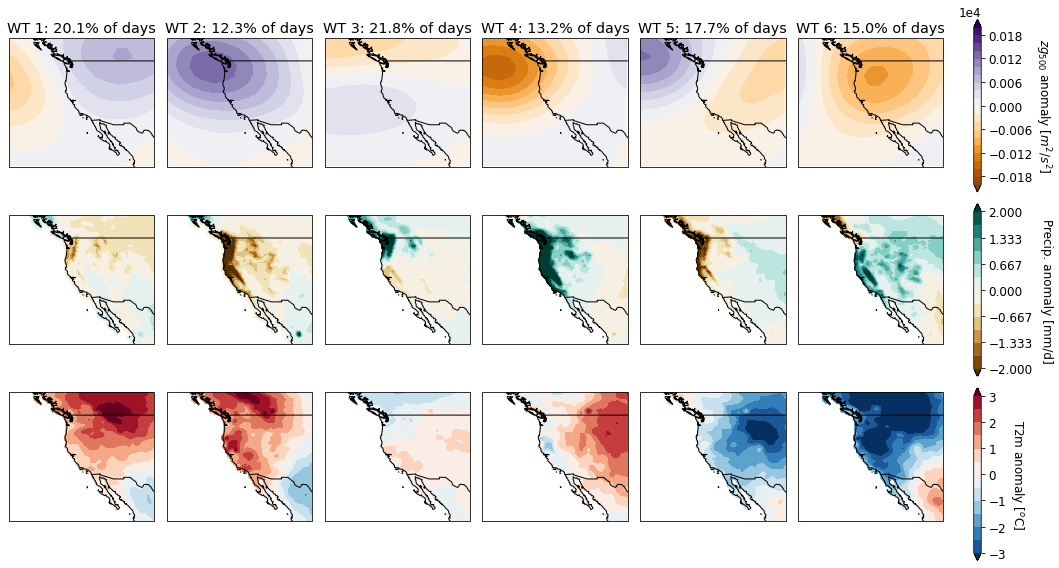

In [ ]:
xmin,xmax = reanalysis['X'].min(), reanalysis['X'].max()
ymin,ymax = reanalysis['Y'].min(), reanalysis['Y'].max()

# Set up the Figure
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(
        nrows=3, ncols=len(wt_unique), subplot_kw={'projection': map_proj}, 
        figsize=figsize, sharex=True, sharey=True
    )

# Loop through
for i,w in enumerate(wt_unique):
    def selector(ds):
        times = wt.loc[wt['WT'] == w].index
        typ = np.in1d(ds.unstack('time')['T'], times)
        ds = ds.sel(time = np.in1d(ds.unstack('time')['T'], times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Top row: geopotential height anomalies
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(w, wt_counts.values[i]))
    C0 = selector(reanalysis['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap='PuOr',
        extend="both",
        levels=np.linspace(-2e2, 2e2, 21),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -65, -12, 12])

#     # add wind arrows
#     U = selector(uwnd).adif.values  
#     V = selector(vwnd).adif.values
#     magnitude = np.sqrt(U**2 + V**2)
#     strongest = magnitude > np.percentile(magnitude, 50)
#     Q = ax.quiver(
#         X[strongest], Y[strongest], U[strongest], V[strongest], 
#         transform=data_proj, 
#         width=0.001, scale=0.8,units='xy'
#     )

    # Middle row: rainfall anomalies
    ax = axes[1, i]
    C1 = selector(rainfall['adif']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'BrBG',
        extend="both",
        levels=np.linspace(-2, 2, 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -75, -9, 5])

    #Bottom row: tepmperature anomalies
    ax = axes[2, i]
    C2 = selector(t2m['asum']).unstack('grid').plot.contourf(
        transform = data_proj,
        ax=ax,
        cmap = 'RdBu_r',
        extend="both",
        levels=np.linspace(-3, 3, 13),
        add_colorbar=False,
        add_labels=False
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([-95, -70, -9, 5])
    ax.tick_params(colors='b')

# # Add Colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cax0 = fig.add_axes([0.97, 0.65, 0.0075, 0.3])
cax1 = fig.add_axes([0.97, 0.33, 0.0075, 0.3])
cax2 = fig.add_axes([0.97, 0.01, 0.0075, 0.3])
cbar0 = fig.colorbar(C0, cax = cax0)
cbar0.formatter.set_powerlimits((4, 4))
cbar0.update_ticks()
cbar0.set_label(r'$zg_{500}$ anomaly [$m^2$/$s^2$]', rotation=270)
cbar0.ax.get_yaxis().labelpad = 20
cbar1 = fig.colorbar(C1, cax=cax1)
cbar1.set_label('Precip. anomaly [mm/d]', rotation=270)
cbar1.ax.get_yaxis().labelpad = 20
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label('T2m anomaly [$^o$C]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 20

# Format these axes


#Add plot labels
# letters = string.ascii_lowercase
# for i, ax in enumerate(axes.flat):
#    label = '({})'.format(letters[i])
#    t = ax.text(0.05, 0.9, label, fontsize=11, transform=ax.transAxes)
#    t.set_bbox(dict(facecolor='white', edgecolor='gray'))

# Add a quiver key
#k = plt.quiverkey(Q, 0.9, 0.7, 1, '1 m/s', labelpos='E', coordinates='figure')

#fig.savefig('figs/wt_composite.pdf', bbox_inches='tight')
plt.show()

A final optional plot which shows reanalysis data using a north polar stereographic projection.

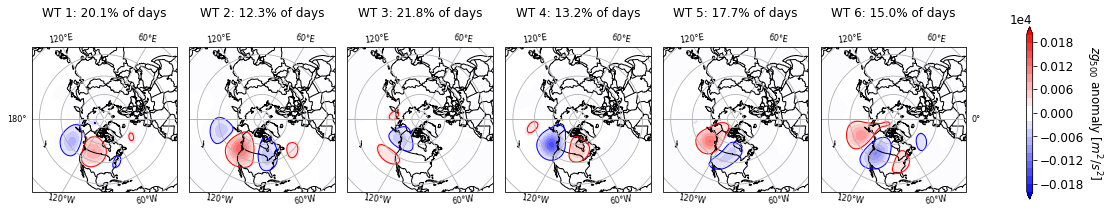

In [34]:
plt.rcParams.update({'font.size': 12})
projection = ccrs.NorthPolarStereo(central_longitude=-90)

#These would be used if you are to use the circular bounding box
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5,0.5], 0.45
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)

fig, axes = plt.subplots(
        nrows=1, ncols=len(wt_unique), subplot_kw={'projection': projection},  
        figsize=(14,8), sharex=True, sharey=True,
    )

def selector(ds):
    times = wt.loc[wt['WT'] == w].index
    ds = ds.sel(time = np.in1d(ds.unstack('time')['T'], times))
    ds = ds.mean(dim = 'time')
    return(ds)

for i,w in enumerate(wt_unique):
    ax = axes[i]
        #below commented code to create circle bounding box instead of rectangle issue with cutting out coordinate markers
        # 'https://github.com/SciTools/cartopy/issues/1559' , 
        # 'https://stackoverflow.com/questions/70844204/how-to-display-lat-lon-tick-labels-with-custom-boundary-shape-in-cartopy'
    #ax.set_boundary(circle, transform=ax.transAxes)
    gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=True) 
    gl.xpadding=3
    gl.xlabel_style = {'size': 8} 
    gl.ylabel_style = {'size': 0, 'color':'white'} #so that the y labels do not show up.. probably a better way to do this
    if i == 0:
        gl.right_labels=False
        gl.left_lables=True
    elif i == (wt_unique[-1]-1):
        gl.right_labels=True
        gl.left_labels=False  
    else:
        gl.right_labels=False
        gl.left_labels=False 
    C0 = selector(reanalysisFull['adif']).unstack('grid').plot.contourf( #first map layer to add shaded contour 
        transform =data_proj,
        ax=ax,
        cmap= cmap0,
        extend="both",
        levels=np.linspace(-2e2, 2e2, 21),
        add_colorbar=False,
        add_labels=True
    )
    C1 = selector(reanalysisFull['adif']).unstack('grid').plot.contour( #second map layer to add outline shapes
        transform=data_proj,
        ax=ax,
        extend="both",
        levels= np.linspace(-2e2,2e2,10),
        colors=('blue', 'blue','blue','blue','blue','red','red','red','red', 'red'),
        linewidths=(0,0,0,0,1,1,0,0,0,0),
    )
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_frame_on(True)
    ax.set_title('WT {}: {:.1%} of days'.format(w, wt_counts.values[i]), fontsize=12,pad=16)
        #extent from bounding box calculation instead of actual coordinates; need to figure out how to
        #reproduce values to make more extensible 
    # 'https://stackoverflow.com/questions/56248063/cartopy-set-extent-with-northpolestereo-not-working'
    ax.set_extent([-10001000.098850504, 10001000.098850504, -10001000.098850504, 10001000.098850504],crs=projection)
plt.tight_layout()
fig.subplots_adjust(bottom=.6,right=0.94)
cax0 = fig.add_axes([1, 0.65, 0.006, 0.3])
cbar0 = fig.colorbar(C0, cax = cax0)
cbar0.formatter.set_powerlimits((4, 4))
cbar0.update_ticks()
cbar0.set_label(r'$zg_{500}$ anomaly [$m^2$/$s^2$]', rotation=270)
cbar0.ax.get_yaxis().labelpad = 20
cbar0.ax.get_xaxis().labelpad = 20

#fig.savefig('figs/zg_polarStereo.pdf', bbox_inches='tight')